In [ ]:
from pybit._v5_market import MarketHTTP
import time
from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np
import datetime
import timesfm

market = MarketHTTP(
    testnet=False
)
tfm = timesfm.TimesFm(
    context_len=1024,
    horizon_len=100,
    input_patch_len=32,
    output_patch_len=128,
    num_layers=20,
    model_dims=1280,
    backend='gpu',
)
tfm.load_from_checkpoint(repo_id="google/timesfm-1.0-200m")

In [510]:
# GET STOCK DATA
#=========================================================
COINPAIR = 'BTCUSDT'
intrvl = 15  # Chart step
pages = 3  # Affects the result!
#=========================================================
data = []
last_time = time.time()*1000
for i in range(pages):
    end_time = last_time
    start_time = end_time - (1000*intrvl*60000)
    
    result = market.get_index_price_kline(
        category='linear',
        symbol=COINPAIR,
        interval=str(intrvl),
        start=start_time,
        end=end_time,
        limit=1000
    )
    data.extend(result.get('result').get('list'))
    last_time = int(start_time) - intrvl*60000
data = data[::-1]
    
print(len(data))
# print(data)

times = [int(item[0]) for item in data]
prices = [float(item[4]) for item in data]

3000


2024-07-13 06:15:00


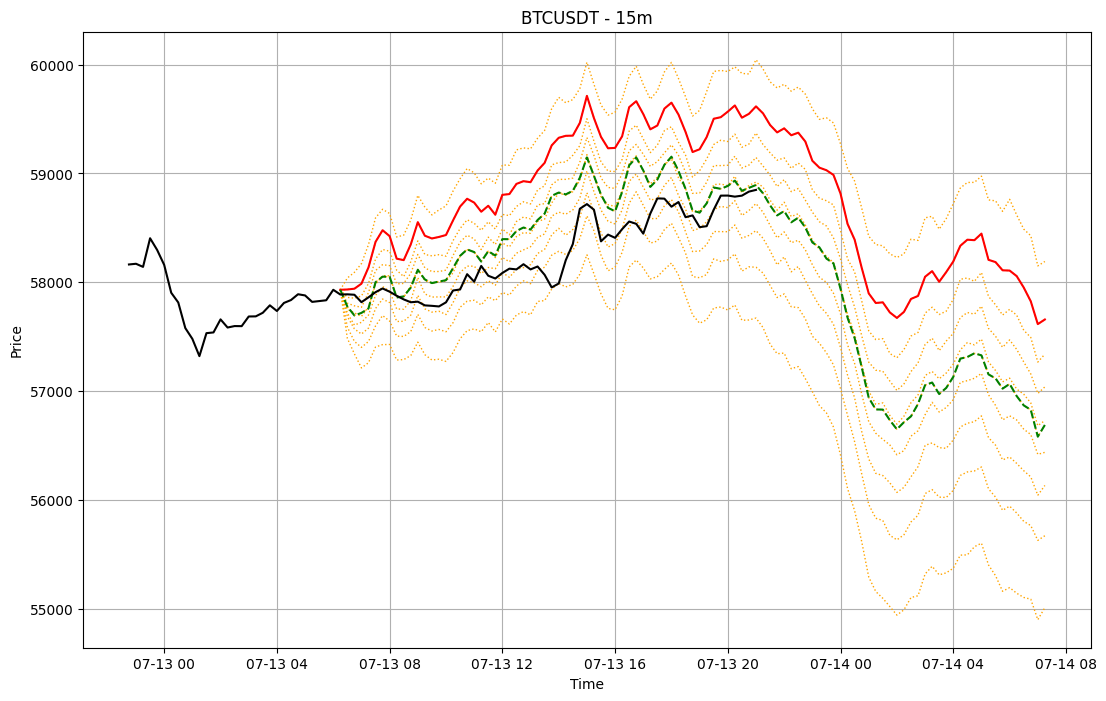

In [519]:
#=========================================================
shift = 60
#=========================================================
learn_prices = prices[:-shift] if shift else prices
learn_times = times[:-shift] if shift else times

[fdata], [experimental_quantile_forecast] = tfm.forecast(
    [learn_prices],
    # freq=[0 for _ in range(2)],
    # window_size=2
    freq=[0],
)
# print(fdata)
# print(learn_prices[-1])
# print(prices[-(shift+1)])
# print('-----------------')
# print(times)
# print(experimental_quantile_forecast)

dt_times = [datetime.datetime.fromtimestamp(time / 1000) for time in times]

start_fc_point = times[-(shift or 1)]
step_sec = 60000*intrvl
fcst_times = [t for t in range(start_fc_point + step_sec,
                               start_fc_point + ((len(fdata)+1)*step_sec),
                               step_sec)]

fcst_times.insert(0, start_fc_point)  # for connecting two charts

fcst_times = [datetime.datetime.fromtimestamp(time / 1000) for time in fcst_times]
print(datetime.datetime.fromtimestamp(start_fc_point
                                      /1000))

plt.figure(figsize=(13, 8))
diffs = []
values = {}
start_price = learn_prices[-1]
for i in range(0, 10):
    diff = abs(experimental_quantile_forecast[0][i] - start_price)
    diffs.append(diff)
    values[i] = [start_price] # for connecting two charts
    for checkpoint in experimental_quantile_forecast:
        values[i].append(checkpoint[i])
    plt.plot(fcst_times, values[i], marker='', linestyle='dotted', linewidth=1, color='orange')
minindex = diffs.index(min(diffs))
min_values = values[minindex]
fdata = np.insert(fdata, 0, start_price) # for connecting two chart

plt.plot(fcst_times, min_values, marker='', linestyle='-', color='red')
plt.plot(fcst_times, fdata, marker='', linestyle='--', color='green')
plt.plot(dt_times[-(30+shift):], prices[-(30+shift):], marker='', linestyle='-', color='black')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{COINPAIR} - {intrvl}m')
plt.grid(True)
plt.show()